In [1]:
import argparse
import time
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unet import ResidualUNet, Denoiser
from utils import save_image, dotdict
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [2]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02, n_skip = 0, lr = 2e-4):
        self.model = model
        self.timesteps = timesteps-n_skip
        self.reversed_time_steps = torch.arange(self.timesteps-1,-1,-1)
        #print(self.reversed_time_steps)
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
        self.alphas = self.alphas[n_skip:]
        self.betas = self.betas[n_skip:]
        self.alphas_cumprod = self.alphas_cumprod[n_skip:]
        self.lr = lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        print(self.alphas_cumprod)

    def forward(self,data, model, alphasb_batch = None):
        im = data
    
        # parameters of the langevin dynamics steps
        ind_randoms= torch.randint(0, self.timesteps, (data.shape[0],), device = data.device)
        
        noise_in = torch.randn_like(im)
        if alphasb_batch is None:
            alphasb_batch = self.alphas_cumprod[ind_randoms]
    
            im_input = (torch.sqrt(1-alphasb_batch)[:,None,None,None]*noise_in+torch.sqrt(alphasb_batch)[:,None,None,None]*im)
        else :
            im_input = im
        
        pred_eps = model(im_input, alphasb_batch)
        score = -pred_eps/torch.sqrt(1-alphasb_batch)[:,None,None,None]
        # corrected image 
        im_corrected = (im_input-torch.sqrt(1-alphasb_batch)[:,None,None,None]*pred_eps)/torch.sqrt(alphasb_batch)[:,None,None,None]
    
        square_norm = torch.sum((pred_eps-noise_in)**2,(1,2,3)) # square norm of loss per image
        loss = square_norm.sum()
        return loss, im_input, im_corrected, pred_eps, score
                

    def sample_sde(self, num_samples, shape=(1,32,32), corr = True):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                alphasb_batch = self.alphas_cumprod[t_tensor]
                loss, im_input, im_corrected, eps, score= self.forward(x, self.model, alphasb_batch)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_t_cumprod))*eps)

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
                if t==0 and corr:
                    print("last corr")
                    x = im_corrected
        return x

    def sample_ode(self, num_samples, shape=(1,32,32), corr = True, mode="euler"):
        with torch.no_grad(): # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                x = self.ode_step(x,t_tensor, mode=mode)
        return x

    def get_ode_trajectory(self, num_samples, shape=(1,32,32), corr = True, mode="euler"):
        traj = []
        with torch.no_grad(): # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            traj.append(x)
            for i, t in enumerate(self.reversed_time_steps):
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                x = self.ode_step(x,t_tensor, mode=mode)
                traj.append(x)
        return traj
        
    def ode_step(self, x, t_tensor, corr = True, mode="euler"):
        if mode == "euler":
            with torch.no_grad():
                alphasb_batch = self.alphas_cumprod[t_tensor]
                loss, im_input, im_corrected, pred_eps, score= self.forward(x, self.model, alphasb_batch)
                beta_t = self.betas[t_tensor]
                xip = (2-torch.sqrt(1-beta_t))[:,None,None,None]*x+1/2*beta_t[:,None,None,None]*score
                x = xip# + torch.sqrt(beta_t)*noise
                if corr:
                    x = torch.where((t_tensor==0)[:,None,None,None],im_corrected,x)
        elif mode=="heun":
            with torch.no_grad():
                alphasb_batch = self.alphas_cumprod[t_tensor]
                loss, im_input, im_corrected, pred_eps, score= self.forward(x, self.model, alphasb_batch)
                beta_t = self.betas[t_tensor]
                xip = (2-torch.sqrt(1-beta_t))[:,None,None,None]*x+1/2*beta_t[:,None,None,None]*score
                loss, im_input, im_corrected, pred_eps, scorep= self.forward(x, self.model, alphasb_batch)
                nscore = (score+scorep)/2
                x = (2-torch.sqrt(1-beta_t))[:,None,None,None]*x+1/2*beta_t[:,None,None,None]*nscore
                if corr:
                    x = torch.where((t_tensor==0)[:,None,None,None],im_corrected,x)
        return x
    

    def load(self, path):
        """Load the model's state from a file."""
        self.model.load_state_dict(torch.load(path, map_location=next(model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.model.state_dict(), path)

    def add_noise(self,batch,t_tensor):
        noise = torch.randn_like(batch, dtype=torch.float32)
        noisy_data = torch.sqrt(self.alphas_cumprod[t_tensor]).view(-1, 1,1,1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t_tensor]).view(-1, 1,1,1) * noise
        return noisy_data

    def train(self, dataloader, epochs=1000, batch_size=64, warmup=True):
        criterion = nn.MSELoss()
        
        losses = []
        mean_loss = 0
        i = 0
        if warmup:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = 0.0
        for epoch in range(epochs):
            for x, idx in tqdm(dataloader):
                x = x.to(device)
                self.optimizer.zero_grad()
                loss, im_input, im_corrected, pred_eps, score= self.forward(x, self.model)
                mean_loss+=loss.item()
                i+=1
                loss.backward()
                self.optimizer.step()

            if epoch % 1 == 0:
                losses.append(mean_loss/i)
                print(f'Epoch {epoch}, Loss: {mean_loss/i}')
                mean_loss = 0
                i = 0
            if epoch==1 and warmup:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr
        return losses
    


In [3]:

TEST = False# set to true to load model from disk and only generate to test langevin

# Training settings
args_dict = {'batch_size' : 64, 'test_batch_size' :64, 'epochs' :1000, 'lr' : 0.0002, 'gamma' : 0.995, 'no_cuda' :False, 
             'dry_run':False, 'seed': 1, 'log_interval' : 200, 'save_model' :True, 'only_test':False, 'model_path':"models/denoisermnist-Copy1.pt", 
             'load_model_from_disk':True, 'dataset':"MNIST", 'test':False}
args = dotdict(args_dict)
#parser = argparse.ArgumentParser(description="A simple argument parser example.")

# Add arguments
#parser.add_argument('--dataset', type=str, required=False, default = 'MNIST', help='Dataset can be one of MNIST, CIFAR, CELEBA')
#parser.add_argument('--test', type= str, required = False, help='wether to only test a model, requires path to the testing weights')

# Parse the arguments
#margs = parser.parse_args()
#args.dataset = margs.dataset
#if margs.test is not None:
#    print("TEST")
#    args.test = True
#    print(args.test)
#    args.model_path = margs.test

if args.test:
    print("TEST")
    args.load_model_from_disk = True
    args.only_test = True
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

dataset = args.dataset
if dataset == "CIFAR":
    transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),#mean, std
    transforms.RandomHorizontalFlip(p=0.5)
    ])

    dataset1 = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
    dataset2 = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    model = Denoiser(4,3).to(device)
elif dataset == "CELEBA":
    transform = transforms.Compose([transforms.Resize((64,64)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5])])
    dataset1 = datasets.CelebA("./data/celeba", split = 'train',download=False, transform=transform)
    dataset2 = datasets.CelebA("./data/celeba", split = 'test', download=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    model = Denoiser(3,3).to(device)

elif dataset=="MNIST":
    # loading dataset
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = datasets.MNIST('./data/mnist', train=True, download=True,
    transform=transform)
    dataset2 = datasets.MNIST('./data/mnist', train=False,
    transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Denoiser(1,1).to(device)

if args.load_model_from_disk:
    model.load_state_dict(torch.load(args.model_path, weights_only= True))

ddpm = DDPM(model, timesteps=80, beta_start = 5e-3, beta_end = 0.2, n_skip=5)

tensor([9.3477e-01, 9.1625e-01, 8.9584e-01, 8.7367e-01, 8.4989e-01, 8.2466e-01,
        7.9815e-01, 7.7052e-01, 7.4194e-01, 7.1259e-01, 6.8264e-01, 6.5227e-01,
        6.2164e-01, 5.9091e-01, 5.6024e-01, 5.2978e-01, 4.9967e-01, 4.7004e-01,
        4.4101e-01, 4.1268e-01, 3.8515e-01, 3.5850e-01, 3.3282e-01, 3.0815e-01,
        2.8455e-01, 2.6206e-01, 2.4070e-01, 2.2048e-01, 2.0142e-01, 1.8351e-01,
        1.6674e-01, 1.5109e-01, 1.3653e-01, 1.2304e-01, 1.1058e-01, 9.9112e-02,
        8.8586e-02, 7.8959e-02, 7.0184e-02, 6.2210e-02, 5.4989e-02, 4.8471e-02,
        4.2605e-02, 3.7344e-02, 3.2641e-02, 2.8449e-02, 2.4725e-02, 2.1428e-02,
        1.8518e-02, 1.5957e-02, 1.3711e-02, 1.1747e-02, 1.0036e-02, 8.5486e-03,
        7.2609e-03, 6.1493e-03, 5.1926e-03, 4.3720e-03, 3.6703e-03, 3.0721e-03,
        2.5638e-03, 2.1333e-03, 1.7699e-03, 1.4640e-03, 1.2073e-03, 9.9266e-04,
        8.1373e-04, 6.6504e-04, 5.4188e-04, 4.4019e-04, 3.5650e-04, 2.8784e-04,
        2.3169e-04, 1.8593e-04, 1.4874e-

In [4]:
#ddpm.train(train_loader, epochs=40)

In [5]:
def plot_mnist_batch(images_tensor, n_images=64):
    # Move the tensor to CPU and convert to NumPy
    images_cpu = images_tensor.cpu().numpy()

    # Assuming the tensor shape is (batch_size, 1, 28, 28)
    # Plot the first n_images in the batch
    fig, axes = plt.subplots(8,8, figsize=(10, 10))
    for i in range(n_images):
        ax = axes[i//8,i%8]
        ax.imshow(images_cpu[i, 0], cmap='gray')
        ax.axis('off')
    plt.show()


In [6]:
images_eul = ddpm.sample_ode(64, mode="euler")
#images_corr = ddpm.sample_sde(64, corr=False)

/tmp/ipykernel_122869/1980701750.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)


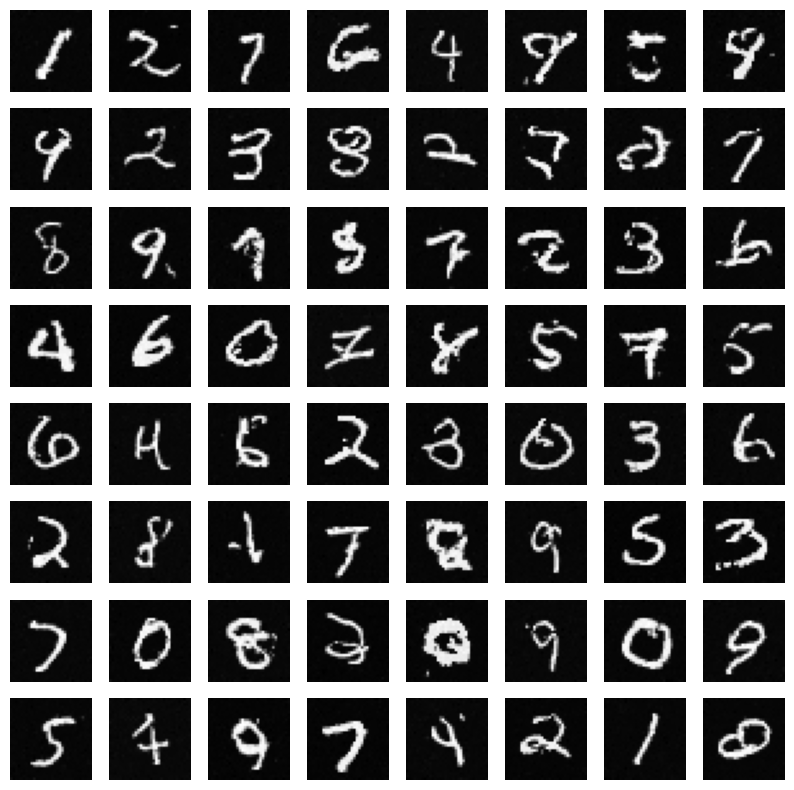

In [7]:
plot_mnist_batch(images_eul)

In [8]:
import copy
import random
from tqdm import tqdm
class ConsistencyModel:
    def __init__(self, student_model, teacher_model, learning_rate=2e-4, mu=0.95):
        self.student_model = student_model  # Consistency model
        self.teacher_model = teacher_model  # Pretrained DDPM model
        self.timesteps =  teacher_model.timesteps
        self.learning_rate = learning_rate
        self.mu = mu  # EMA parameter
        self.optimizer = optim.Adam(self.student_model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.theta_minus_model = self.create_ema_model()
    
    def create_ema_model(self):
        """ Create a copy of the student model for EMA tracking """
        ema_model = copy.deepcopy(self.student_model)
        for param in ema_model.parameters():
            param.requires_grad = False  # Freeze EMA model
        return ema_model.to(device)
    
    def update_ema(self):
        """ Exponential Moving Average (EMA) update for θ⁻ """
        with torch.no_grad():
            for param, param_ema in zip(self.student_model.parameters(), self.theta_minus_model.parameters()):
                param_ema.data = self.mu * param_ema.data + (1 - self.mu) * param.data

    def sample(self,num_samples, im_shape):
        x = torch.randn((num_samples,)+im_shape, dtype=torch.float32, device=device)
        with torch.no_grad():
            return self.student_model(x, self.teacher_model.alphas_cumprod[-1]*torch.ones((num_samples,), device = device))
        
        
    def load(self, path):
        """Load the model's state from a file."""
        self.student_model.load_state_dict(torch.load(path, map_location=next(student_model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.student_model.state_dict(), path)
        
    def train(self, train_loader, test_loader, epochs=100, batch_size=64):
        for epoch in range(epochs):
            epoch_loss = 0
            i=0
            for x,label in tqdm(train_loader):
                i+=1
                x = x.to(device)
                self.optimizer.zero_grad()
                
                # Sample t_n and t_{n+1}
                n = torch.randint(0, self.timesteps - 2, (x.size(0),), device=x.device)
                t_n = n   # Select t_n
                
                t_np1 = t_n+1  # Select t_n+1
                
                # Sample x_{t_{n+1}}
                #noise = torch.randn_like(x, device=x.device)
                
                x_tnp1 = self.teacher_model.add_noise(x, t_np1)
                alphas_cumprod_t = self.teacher_model.alphas_cumprod[t_n]
                alphas_cumprod_tp1 = self.teacher_model.alphas_cumprod[t_np1]
                
                # Compute teacher output (ODE solver)
                with torch.no_grad():
                    x_hat_tn = self.teacher_model.ode_step(x_tnp1, t_np1)
                    #x_hat_phi_tn = x_tnp1 - t_np1.view(-1, 1) * (t_n.view(-1, 1) - t_np1.view(-1, 1)) * phi_tn
                
                # Compute student output
                student_output = self.student_model(x_tnp1, alphas_cumprod_tp1)
                
                with torch.no_grad():  # Stop gradient flow
                    theta_minus_output = torch.where((t_n==0)[:,None,None,None],x,self.theta_minus_model(x_hat_tn, alphas_cumprod_t))
                    #theta_minus_output=self.teacher_model.add_noise(x,t_n)
                
                # Compute loss
                # loss = self.loss_fn(student_output, theta_minus_output)
                loss = self.loss_fn(student_output, theta_minus_output)
                
                loss.backward()
                self.optimizer.step()
                
                # EMA update
                if i%1==0:
                    self.update_ema()
                
                epoch_loss += loss.item()
        
            print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}")
            # Evaluate on test set every 2 epochs
            if epoch % 1 == 0:
                test_loss = 0
                with torch.no_grad():
                    for x, label in tqdm(test_loader):
                        x = x.to(device)
                        n = torch.randint(0, self.timesteps - 2, (x.size(0),), device=x.device)
                        t_n = n
                        t_np1 = t_n + 1
                        x_tnp1 = self.teacher_model.add_noise(x, t_np1)
                        alphas_cumprod_t = self.teacher_model.alphas_cumprod[t_n]
                        student_output = self.student_model(x_tnp1, alphas_cumprod_t)
                        theta_minus_output = self.theta_minus_model(x_tnp1, alphas_cumprod_t)
                        loss = self.loss_fn(student_output, theta_minus_output)
                        test_loss += loss.item()
                images = self.sample(64,(1,32,32))
                plot_mnist_batch(images)
        
                avg_test_loss = test_loss / len(test_loader)
                print(f"Epoch {epoch}, Test Loss: {avg_test_loss}")
        return self.student_model
        
    def trainp(self, data, epochs=100, batch_size=64):
        
        for epoch in range(epochs):
            epoch_loss = 0
            i=0
            
            random.shuffle(data)
            for i in tqdm(range(len(data)//batch_size-1)):
                i+=1
                self.optimizer.zero_grad()
            
                batch = data[batch_size*i:batch_size*(i+1)]
                images_in = torch.cat([data_point[0][None,:,:,:] for data_point in batch], dim=0).to(device)
                images_real = torch.cat([data_point[1][None,:,:,:] for data_point in batch], dim=0).to(device)
                alphasb_batch = torch.Tensor([data_point[2] for data_point in batch]).to(device)
                student_output = self.student_model(images_in, alphasb_batch)
                loss = self.loss_fn(student_output, images_real)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                    
                
                #for i in range(len(traj)):
                #    student_output = self.student_model(traj[i], self.teacher_model.alphas_cumprod[-i]*torch.ones((im_batch_size,), device=device))
                #    loss = self.loss_fn(student_output, x)
                #    loss.backward()
                #    self.optimizer.step()
                #    epoch_loss += loss.item()
        
            print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}")
            # Evaluate on test set every 2 epochs
            if epoch % 1 == 0:
                images = self.sample(64,(1,32,32))
                plot_mnist_batch(images)
        return self.student_model

In [16]:
data = []
batch_size = 32
for i in tqdm(range(100)):
        im_batch_size = batch_size
        with torch.no_grad():
            traj = ddpm.get_ode_trajectory(im_batch_size,(1,32,32))
        
        x = traj[-1]
        #plot_mnist_batch(x)
        for i in range(len(traj)):
            for j in range(im_batch_size):
                data.append((traj[i][j].cpu(),x[j].cpu(),ddpm.alphas_cumprod[-i].cpu()))

  0%|                | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_122869/1980701750.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
100%|██████| 100/100 [01:51<00:00,  1.12s/it]


In [21]:

# Specify the path where you want to save the model
model_path = 'models/student_model.pth'
student_model = Denoiser(1,1).to(device)
student_model.load_state_dict(model.state_dict())


<All keys matched successfully>

In [28]:
# Load the state dictionary from the file
student_model.load_state_dict(torch.load(model_path))


/tmp/ipykernel_122869/3550940336.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [23]:
consistency_model = ConsistencyModel(student_model, ddpm)

100%|████| 7599/7599 [04:29<00:00, 28.23it/s]


Epoch 0, Loss: 0.17311175202708573


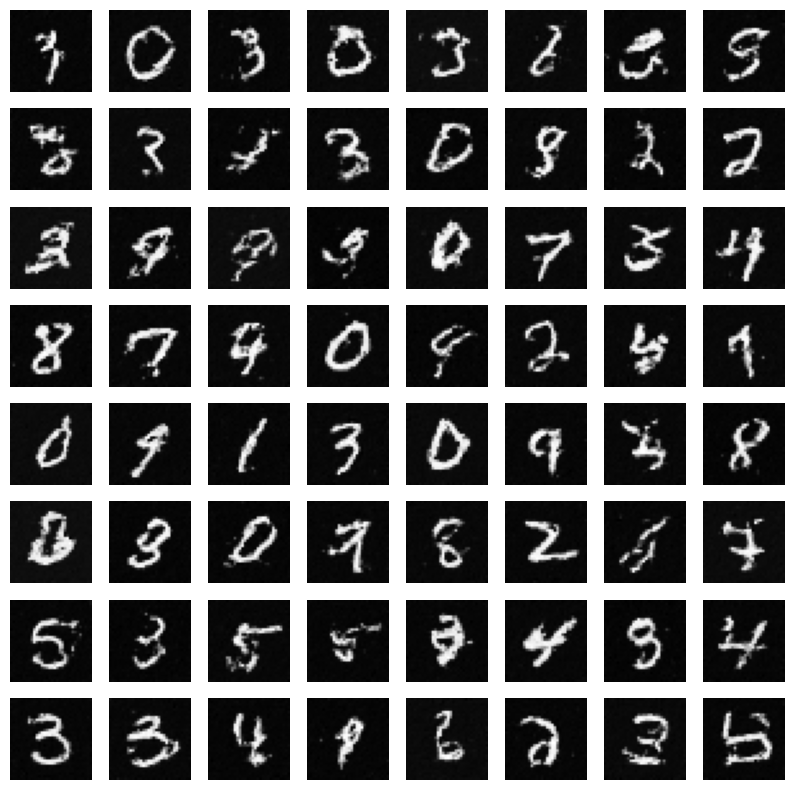

In [25]:

student_model = consistency_model.trainp(data, epochs=1, batch_size=32)

In [ ]:

# Save the model's state dictionary to disk
#torch.save(student_model.state_dict(), model_path)

In [29]:
x = consistency_model.sample(64,(1,32,32))

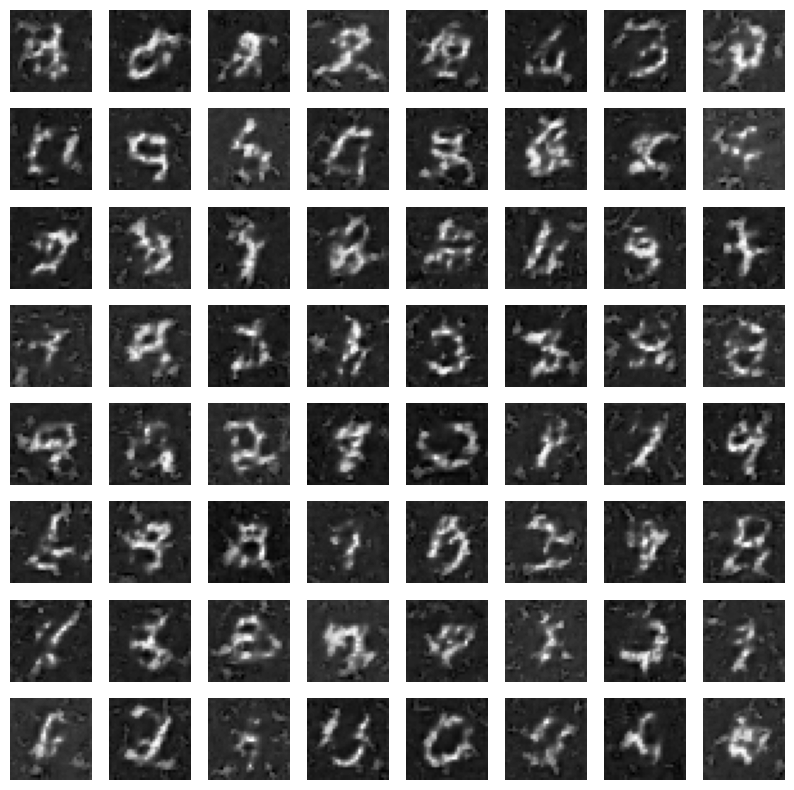

In [30]:
plot_mnist_batch(x)